In [1]:
import tqdm
import umap
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import jax
import jax.numpy as jnp

from methods import Hexagon

In [2]:
# utilities
def rotate(x, theta):
    m = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return m@x

def relu(x):
    return jnp.maximum(0, x)

In [3]:
# 🔪 JAX 🔪
def grid_func(r, k, phi):
    rhat = r[None] - phi
    kr = jnp.tensordot(rhat, k, axes = (-1, -1))
    g = relu(1/len(k)*jnp.sum(jnp.cos(kr), axis = -1))#+1/len(k))
    return g

def jacobian(r, k, phi):
    return jax.jacfwd(grid_func)(r, k, phi) # default is zeroth argument of function

def jacobian_determinant(r, k, phi):
    J = jacobian(r, k, phi)
    return jnp.sqrt(jnp.linalg.det(jnp.dot(J.T, J)))

def jacobian_determinant_jacobian(r,k,phi):
    return jax.jacfwd(jacobian_determinant)(r, k, phi)

def batch_jacobian_determinant_jacobian(r,k,phi):
    return jax.vmap(jacobian_determinant_jacobian,(0,None,None))(r,k,phi)

def batch_jacobian_determinant(r, k, phi):
    return jax.vmap(jacobian_determinant, (0, None, None))(r, k, phi)

def batch_grid_func(r, k, phi):
    return jax.vmap(grid_func, (0, None, None))(r, k, phi)

In [4]:
# Adam optimizer :)

def init_adam(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # m = mean, v = variance, w = weigths, b = bias
    params = {}
    params["m_dw"] = 0
    params["v_dw"] = 0 
    params["m_db"] = 0
    params["v_db"] = 0
    params["beta1"] = beta1
    params["beta2"] = beta2
    params["epsilon"] = epsilon
    params["lr"] = lr
    return params

def adam_step(params, t, w, b, dw, db): 
    # Enoch Kan implementation, but declassified B)
    # https://towardsdatascience.com/how-to-implement-an-adam-optimizer-from-scratch-76e7b217f1cc

    ## dw, db are from current minibatch
    ## momentum beta 1
    # *** weights *** #
    params["m_dw"] = params["beta1"]*params["m_dw"] + (1-params["beta1"])*dw
    # *** biases *** #
    params["m_db"] = params["beta1"]*params["m_db"] + (1-params["beta1"])*db

    ## rms beta 2
    # *** weights *** #
    params["v_dw"] = params["beta2"]*params["v_dw"] + (1-params["beta2"])*(dw**2)
    # *** biases *** #
    params["v_db"] = params["beta2"]*params["v_db"] + (1-params["beta2"])*(db)

    ## bias correction
    m_dw_corr = params["m_dw"]/(1-params["beta1"]**t)
    m_db_corr = params["m_db"]/(1-params["beta1"]**t)
    v_dw_corr = params["v_dw"]/(1-params["beta2"]**t)
    v_db_corr = params["v_db"]/(1-params["beta2"]**t)

    ## update weights and biases
    w = w - params["lr"]*(m_dw_corr/(jnp.sqrt(v_dw_corr)+params["epsilon"]))
    b = b - params["lr"]*(m_db_corr/(jnp.sqrt(v_db_corr)+params["epsilon"]))
    return w, b, params

In [5]:
# loss and parameter step 
#def loss(r, k, phi):
#    det = batch_jacobian_determinant(r, k, phi)
#    mu = jnp.mean(det)
#    return jnp.mean((mu - det)**2)

def loss(r, k, phi):
    return jnp.mean((batch_jacobian_determinant_jacobian(r, k, phi))**2)

def variance(r, k, phi):
    det = batch_jacobian_determinant(r, k, phi)
    mu = jnp.mean(det)
    return jnp.mean((mu - det)**2)

@jax.jit
def update(r, k, phi, lr, step = 0):
    # SGD 😵‍💫
    grads = jax.grad(loss, 2)(r, k, phi)
    # please put Adam here
    return phi - lr*grads

@jax.jit
def adam_update(r, k, phi, params, step):
    # gradient descent; Adam update
    grads = jax.grad(loss, 2)(r, k, phi)
    # note; no bias in model, no bias update!
    phi, _, params = adam_step(params, step, phi, 0, grads, 0)
    return phi, params

In [6]:
def init_model(n, n_waves = 3, theta = np.pi/3, random_seed = True):
    # make model parameters
    if random_seed:  
        key = jax.random.PRNGKey(np.random.randint(0, int(1e16))) # random seed
        key, subkey = jax.random.split(key)
    else:
        key = jax.random.PRNGKey(0) # random seed ish
        subkey = key
        
    f = 1
    k = 2*np.pi*f*jnp.array([rotate(np.array([1,0]), i*theta) for i in range(n_waves)])
    hexagon = Hexagon(f/np.sqrt(3), 0, np.zeros(2))  
    phi = jnp.array(hexagon.sample(n))
    return key, k, phi, hexagon

key, k, phi, hexagon = init_model(1000)
phi0 = np.copy(phi)

In [7]:
# Save jacobian determinant pre-training
n_samples = 100
x = np.linspace(-1, 1, n_samples, endpoint = False) # nice and big region for eval
y = np.linspace(-1, 1, n_samples, endpoint = False)
xx, yy = np.meshgrid(x, y)
u = jnp.stack([xx.ravel(), yy.ravel()], axis = -1).astype("float32")

det_J = batch_jacobian_determinant(u, k, phi)
det_J = np.array(det_J)
det_J_pre_train = np.reshape(det_J, (n_samples, n_samples))

In [8]:
# Train the model!
# hyperparameters 
lr = 1e-3
train_steps = 2500
batch_size = 64 # large batch size for integral estimate

# Train phases
loss_history = []
var_history = []

adam_params = init_adam(lr)

progress = tqdm.tqdm(range(train_steps))
for i in progress:
    key, subkey = jax.random.split(key)
    r = jnp.array(hexagon.sample(batch_size)) # a tad slow
    phi, adam_params = adam_update(r, k, phi, adam_params, step = i+1)
    
    if (i % 10 == 0):
        r = jnp.array(hexagon.sample(2056)) # test sample
        var_val = variance(r, k, phi)
        loss_val = loss(r, k, phi)
        loss_history.append(np.array(loss_val))
        var_history.append(np.array(var_val))
        progress.set_description(f"Mean Var: {var_val:.3E}")

Mean Var: 1.286E+04: 100%|██████████████████| 2500/2500 [02:14<00:00, 18.61it/s]


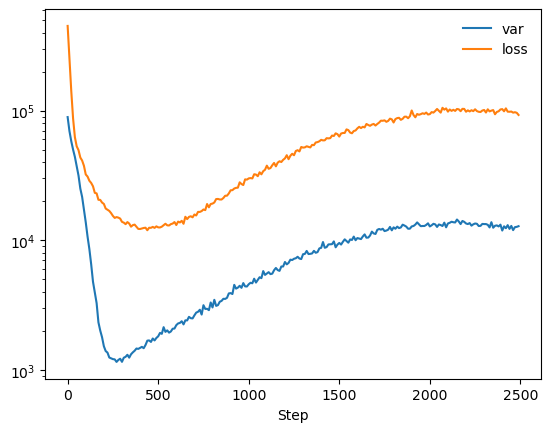

In [9]:
plt.semilogy(np.arange(0, len(var_history)*10, 10), var_history, label = "var")
plt.semilogy(np.arange(0, len(var_history)*10, 10), loss_history, label = "loss")
plt.xlabel("Step")
plt.legend(frameon = False)

In [10]:
# jacobian determinant after training
det_J = np.array(batch_jacobian_determinant(u, k, phi))
det_J = np.reshape(det_J, (n_samples, n_samples))

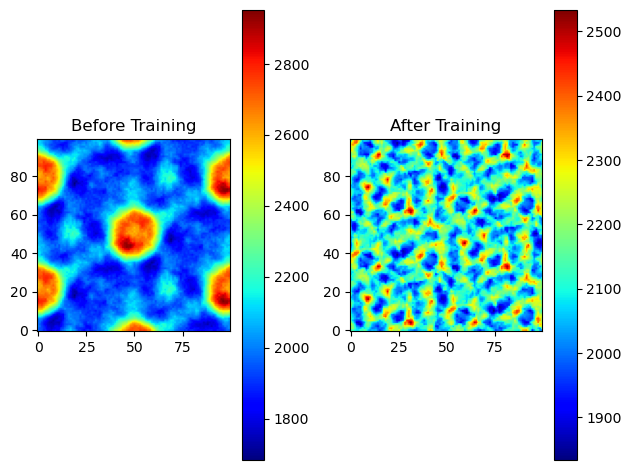

In [11]:
# visualize Jacobian determinants before/after training
fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(det_J_pre_train, origin = "lower", cmap = "jet")
im1 = axs[1].imshow(det_J, origin = "lower", cmap = "jet") 
axs[0].set_title("Before Training")
axs[1].set_title("After Training")
fig.colorbar(im0, ax = axs[0]) # beauty
fig.colorbar(im1, ax = axs[1])
plt.tight_layout()

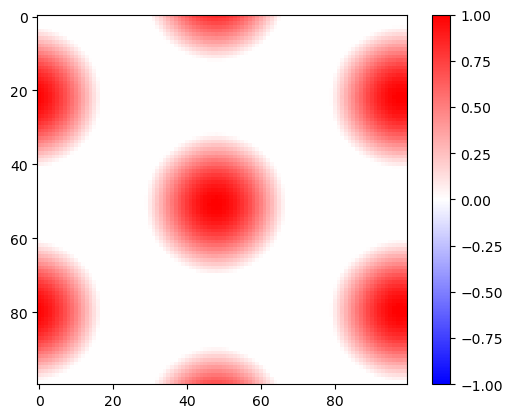

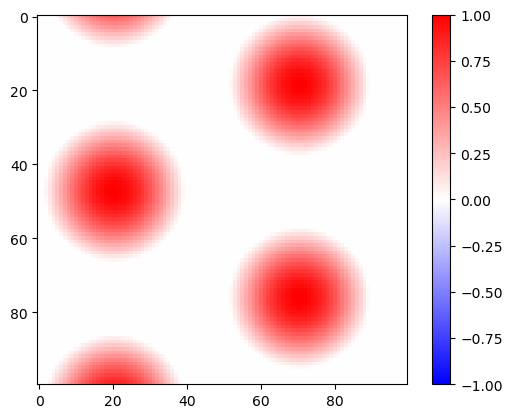

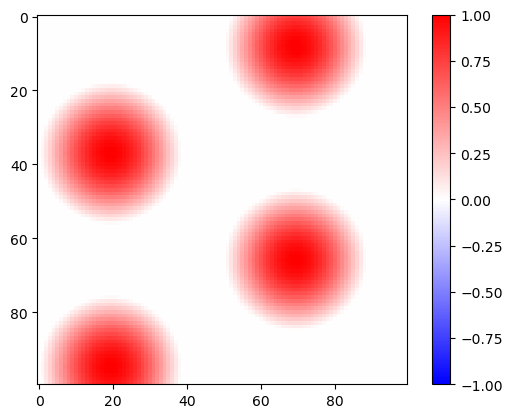

In [12]:
# plot grid functions 
gu = np.array(batch_grid_func(u, k, phi))
g = np.reshape(gu, (n_samples, n_samples, gu.shape[-1]))

for i in range(3):
    plt.imshow(g[...,i], vmin = -1, vmax = 1, cmap= "bwr")
    plt.colorbar()
    plt.show()

(-0.7982181191444397,
 0.9525405049324036,
 -0.7798485815525055,
 0.7442125141620636)

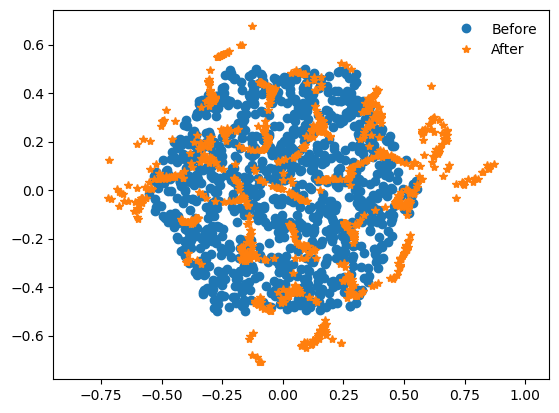

In [13]:
# phases before/after training
plt.plot(*np.array(phi0).T, "o", label = "Before")
plt.plot(*np.array(phi).T, "*", label = "After")
plt.legend(frameon = False)
plt.axis("equal")

(-0.7982181191444397,
 0.9525405049324036,
 -0.7798485815525055,
 0.7442125141620636)

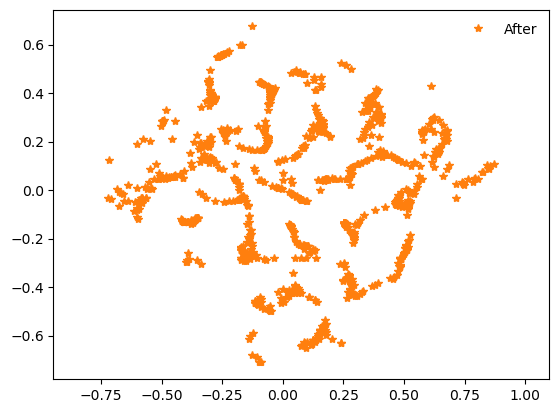

In [14]:
# and just after 
plt.plot(*np.array(phi).T, "*", label = "After", color = "tab:orange")
plt.legend(frameon = False)
plt.axis("equal")

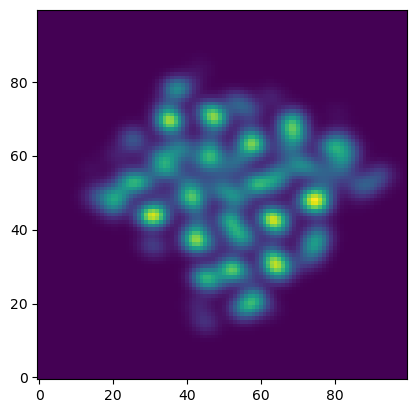

In [15]:
# KDE of phase distribution after training
kde = scipy.stats.gaussian_kde(np.array(phi).T, 0.15)
eval_kde = kde(np.array(u).T)
plt.imshow(eval_kde.reshape(n_samples, n_samples), origin = "lower")